In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

import preprocess # helper preprocessing class

# pyomo
import importlib
import nn_pytorch
import torch

In [2]:
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

# , 'temperature': 'var1'
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

layer_widths = [7, 36, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

In [4]:
from datetime import datetime, timedelta

# prepare data ranges
START_DATE = '2015-01-10'
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
date_sequences = [start_date + timedelta(days=i*5) for i in range(1)]
date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
print(date_sequences_str)

times_elapsed = []

['2015-01-10']


In [5]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

experiment_results = {}

for START_DATE in date_sequences_str:

    data_loader = DataPreprocessor(file_path, start_date = START_DATE, number_of_points = 400, n_days = 1, m = 1, 
                                feature_encoding = encoding, split = 200, equally_spaced = True, 
                                smooth = False, num_nodes_mult = 1)
    data_subsample = data_loader.load_data()
    df_train, df_test = data_loader.preprocess_data(data_subsample)
    
    ys = df_train['y']
    ts = df_train['t']
    Xs = df_train.drop(columns=['y', 't'])

    y0 = torch.tensor(np.array([ys[0]]), dtype=torch.float32)
    ys = torch.tensor(np.atleast_2d(ys).T, dtype=torch.float32)
    ts = torch.tensor(np.array(ts), dtype=torch.float32)
    Xs = np.atleast_2d(Xs) # extra inputs
    
    print(ys.shape, ts.shape, Xs.shape)
    print(y0)
    # break
    ode_model = NeuralODE(layer_widths, learning_rate, time_invariant = True)

    pre_train = True

    for k in [int(len(ts)*0.1), len(ts)]:
        if pre_train:
            ode_model.train_model(ts[:k], ys[:k], y0, num_epochs = 1000, extra_inputs = Xs[:k])
            pre_train = False
        else:
            start_time = time.time()
            ode_model.train_model(ts[:k], ys[:k], y0, num_epochs = 2000, extra_inputs = Xs[:k])
            time_elapsed = time.time() - start_time
    
    y_pred = ode_model.predict(ts, y0, extra_inputs = Xs)
    experiment_results[START_DATE] = {}
    
    experiment_results[START_DATE]['mae'] = np.mean(np.abs(y_pred.detach().numpy().flatten() - ys.detach().numpy().flatten()))
    experiment_results[START_DATE]['time_elapsed'] = time_elapsed

torch.Size([200, 1]) torch.Size([200]) (200, 6)
tensor([-0.9788])
Epoch 0, Loss: 0.21325114369392395
Epoch 100, Loss: 0.21098072826862335
Epoch 200, Loss: 0.20276114344596863
Epoch 300, Loss: 0.2048254907131195
Epoch 400, Loss: 0.19308257102966309
Epoch 500, Loss: 0.18559423089027405
Epoch 600, Loss: 0.1820518672466278
Epoch 700, Loss: 0.17237207293510437
Epoch 800, Loss: 0.1731855869293213
Epoch 900, Loss: 0.207498699426651
Epoch 0, Loss: 1.2365200519561768
Epoch 100, Loss: 0.825207531452179
Epoch 200, Loss: 0.7850674390792847
Epoch 300, Loss: 0.7657892107963562
Epoch 400, Loss: 0.742414653301239
Epoch 500, Loss: 0.7188884615898132
Epoch 600, Loss: 0.7008132934570312
Epoch 700, Loss: 0.6816796064376831
Epoch 800, Loss: 0.6710555553436279
Epoch 900, Loss: 0.6404918432235718
Epoch 1000, Loss: 0.6120597124099731
Epoch 1100, Loss: 0.6025237441062927
Epoch 1200, Loss: 0.5652894377708435
Epoch 1300, Loss: 0.5643987059593201
Epoch 1400, Loss: 0.5181325674057007
Epoch 1500, Loss: 0.4988220632

In [6]:
experiment_results

{'2015-01-10': {'mae': 0.5145147}}

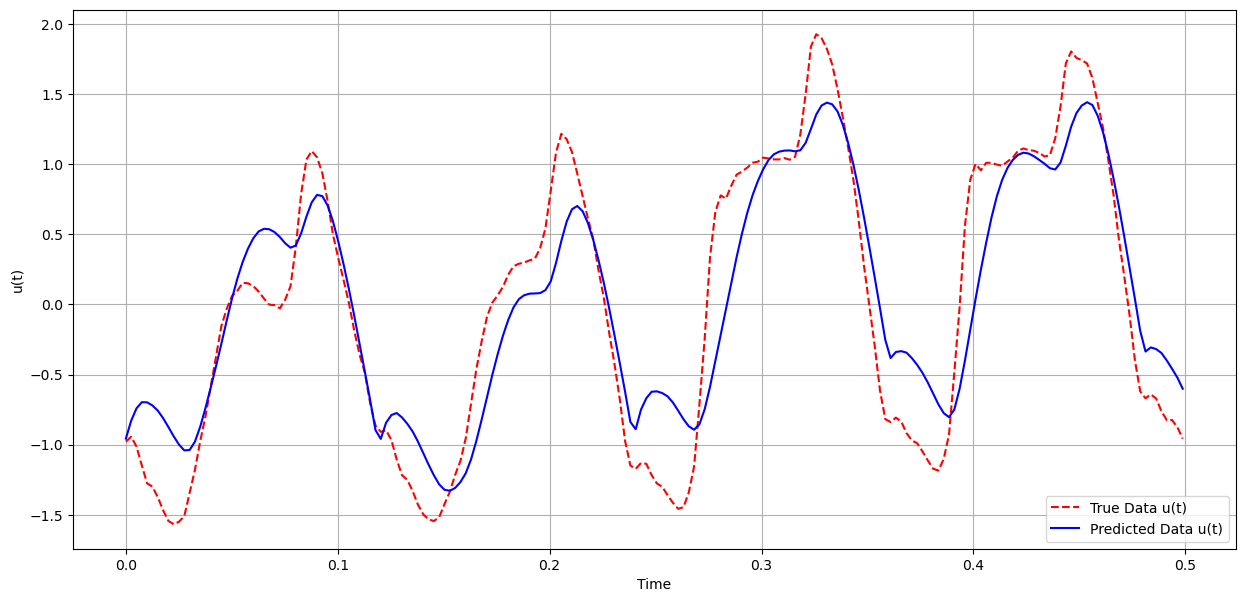

In [56]:
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts, y_pred, 'b', label='Predicted Data u(t)') 
#plt.plot(ts_test, y_test_pred, 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()